In [1]:
%%time

from astropy.stats import mad_std
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import glob
import sys
import os
import gc

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })

warnings.filterwarnings('ignore')

CPU times: user 669 ms, sys: 87.1 ms, total: 756 ms
Wall time: 1.4 s


In [2]:
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [3]:
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr_n.csv')
cayrel = pd.read_csv('tmp_merged/cayrel_atm_fe_cn_corr.csv')

In [4]:
#Part 1: defining good lines

In [5]:
def merge_and_filter_all_lines_cayrel(elem_to_merge, delta_abund_bad = 0.50, std_abund_bad = 0.50, max_no_change_delta_abund = 0.25):
    
    os.system('cat tmp_cayrel/cayrel_elem_lines_%s_*.csv > abunds_merged/cayrel_all_%s_lines_merged.csv' %(elem_to_merge, elem_to_merge));

    elem = pd.read_csv('abunds_merged/cayrel_all_%s_lines_merged.csv' %elem_to_merge, 
                       names=['spec_id','species','wl_line','excit','gflog',elem_to_merge,'e%s_sme' %elem_to_merge,
                              'e%s_fit' %elem_to_merge,'n_iter_%s' %elem_to_merge], comment='s')

    if ion_to_merge != None: elem = elem.query('species == "%s"' %ion_to_merge)
    
    elem_unique_lines_cayrel, elem_unique_lines_cayrel_counts = np.unique(elem.wl_line.values, return_counts=True)
    grouped_stats_elem = elem.groupby('wl_line')[elem_to_merge].agg(['median', mad_std, 'count'])

    argmin_elem = np.argmin(grouped_stats_elem.query('count > 0.50 * %2.2f' %grouped_stats_elem['count'].max())['mad_std'])
    if elem_to_merge == 'ca': argmin_elem = argmin_elem - 1
    if elem_to_merge == 'ti': argmin_elem = argmin_elem - 1
    if elem_to_merge == 'cr': argmin_elem = argmin_elem - 2
    if elem_to_merge == 'eu': argmin_elem = argmin_elem - 1
    if elem_to_merge == 'ba': argmin_elem = argmin_elem + 1
    if elem_to_merge == 'la': argmin_elem = argmin_elem - 1
    elem_ref = elem.query('wl_line == %4.2f' %elem_unique_lines_cayrel[argmin_elem])[elem_to_merge].values

    line_madstd_elem = grouped_stats_elem['mad_std'].values
    line_median_elem = grouped_stats_elem['median'].values
    delta_abund_elem_cayrel = line_median_elem - np.median(elem_ref)

    bad_line_elem_cayrel = (np.abs(delta_abund_elem_cayrel) > delta_abund_bad) | (line_madstd_elem > std_abund_bad)
    if np.sum(bad_line_elem_cayrel) == 0:
        bad_line_elem_cayrel = ~bad_line_elem_cayrel
    delta_abund_elem_cayrel[bad_line_elem_cayrel] = 0.0
    delta_abund_elem_cayrel[np.abs(delta_abund_elem_cayrel) < max_no_change_delta_abund] = 0.0

    print(grouped_stats_elem['median'].values)
    
    # Optional plot
    plt.figure(figsize=(10,4))
    
    plt.errorbar(grouped_stats_elem.index, grouped_stats_elem['median'].values, yerr=grouped_stats_elem['mad_std'].values, fmt='k.', lw=1)
    plt.errorbar(grouped_stats_elem.index, grouped_stats_elem['median'].values - delta_abund_elem_cayrel, yerr=grouped_stats_elem['mad_std'].values, fmt='g.', lw=1, zorder=0)
    plt.hlines(np.median(elem_ref), 3750, 5750, color='C3', lw=2, alpha=0.5)
    plt.scatter(grouped_stats_elem.index[bad_line_elem_cayrel], 6+np.ones_like(grouped_stats_elem.index[bad_line_elem_cayrel]), marker='x', color='r')
    # w = 1./grouped_stats_elem['mad_std'].values[~bad_line_elem_cayrel]**2.
    # w[w < 0.001] = 0.1
    # plt.hlines(np.average(grouped_stats_elem['median'].values[~bad_line_elem_cayrel], weights=w), 3750, 5600, color='C4', lw=2, alpha=0.5)
    # plt.hlines(np.median(grouped_stats_elem['median'].values[~bad_line_elem_cayrel]), 3750, 5750, color='C6', lw=2, alpha=0.5)
    plt.ylabel(r'${\rm %s}$' %ion_to_merge.lower().replace(' ', ''), size=14)
    plt.xlabel(r'${\rm Wavelength\ (\AA)}$', size=14)
    q, eq = grouped_stats_elem['median'].values[~bad_line_elem_cayrel], grouped_stats_elem['mad_std'].values[~bad_line_elem_cayrel]
    eq[eq < 0.001] = 0.1
    plt.title(r'${\rm %s\ =\ %2.2f\ \pm\ %2.2f}$' %(elem_to_merge, np.average(q, weights=1./eq**2.), np.std(q)), size=14)
    
    plt.show()

    print('%s number of lines: %d, good lines: %d' %(elem_to_merge, bad_line_elem_cayrel.size, elem_unique_lines_cayrel[~bad_line_elem_cayrel].size))

    return elem_unique_lines_cayrel, bad_line_elem_cayrel, delta_abund_elem_cayrel

In [6]:
def merge_and_filter_all_nlte_lines_cayrel(elem_to_merge, ion_to_merge = None, delta_abund_bad = 0.50, std_abund_bad = 0.50, max_no_change_delta_abund = 0.25):
    
    os.system('cat tmp_cayrel/cayrel_elem_nlte_lines_%s*.csv > abunds_merged/cayrel_all_%s_nlte_lines_merged.csv' %(elem_to_merge, elem_to_merge));

    elem = pd.read_csv('abunds_merged/cayrel_all_%s_nlte_lines_merged.csv' %elem_to_merge, 
                       names=['spec_id','species','wl_line','excit','gflog',elem_to_merge,'e%s_sme' %elem_to_merge,
                              'e%s_fit' %elem_to_merge,'n_iter_%s' %elem_to_merge], comment='s')

    if ion_to_merge != None: elem = elem.query('species == "%s"' %ion_to_merge)

    elem_unique_lines_cayrel, elem_unique_lines_cayrel_counts = np.unique(elem.wl_line.values, return_counts=True)
    grouped_stats_elem = elem.groupby('wl_line')[elem_to_merge].agg(['median', mad_std, 'count'])

    argmin_elem = np.argmin(grouped_stats_elem.query('count > 0.50 * %2.2f' %grouped_stats_elem['count'].max())['mad_std'])
    if elem_to_merge == 'mg': argmin_elem = argmin_elem - 2
    if elem_to_merge == 'ca': argmin_elem = argmin_elem - 1
    if elem_to_merge == 'ti': argmin_elem = argmin_elem + 1
    if elem_to_merge == 'mn': argmin_elem = argmin_elem + 1
    elem_ref = elem.query('wl_line == %4.2f' %elem_unique_lines_cayrel[argmin_elem])[elem_to_merge].values

    line_madstd_elem = grouped_stats_elem['mad_std'].values
    line_median_elem = grouped_stats_elem['median'].values
    delta_abund_elem_cayrel = line_median_elem - np.median(elem_ref)

    bad_line_elem_cayrel = (np.abs(delta_abund_elem_cayrel) > delta_abund_bad) | (line_madstd_elem > std_abund_bad)
    delta_abund_elem_cayrel[bad_line_elem_cayrel] = 0.0
    delta_abund_elem_cayrel[np.abs(delta_abund_elem_cayrel) < max_no_change_delta_abund] = 0.0

    # # Optional plot
    plt.figure(figsize=(10,4))
    
    plt.errorbar(grouped_stats_elem.index, grouped_stats_elem['median'].values, yerr=grouped_stats_elem['mad_std'].values, fmt='k.', lw=1)
    plt.errorbar(grouped_stats_elem.index, grouped_stats_elem['median'].values - delta_abund_elem_cayrel, yerr=grouped_stats_elem['mad_std'].values, fmt='g.', lw=1, zorder=0)
    plt.hlines(np.median(elem_ref), 3750, 5750, color='C3', lw=2, alpha=0.5)
    plt.scatter(grouped_stats_elem.index[bad_line_elem_cayrel], 6+np.ones_like(grouped_stats_elem.index[bad_line_elem_cayrel]), marker='x', color='r')
    plt.hlines(np.average(grouped_stats_elem['median'].values[~bad_line_elem_cayrel], weights=1./grouped_stats_elem['mad_std'].values[~bad_line_elem_cayrel]**2.), 3750, 5600, color='C4', lw=2, alpha=0.5)
    plt.hlines(np.median(grouped_stats_elem['median'].values[~bad_line_elem_cayrel]), 3750, 5750, color='C6', lw=2, alpha=0.5)
    plt.ylabel(r'${\rm %s\ NLTE}$' %ion_to_merge.lower().replace(' ', ''), size=14)
    plt.xlabel(r'${\rm Wavelength\ (\AA)}$', size=14)
    q, eq = grouped_stats_elem['median'].values[~bad_line_elem_cayrel], grouped_stats_elem['mad_std'].values[~bad_line_elem_cayrel]
    eq[eq < 0.001] = 0.1
    plt.title(r'${\rm %s\ =\ %2.2f\ \pm\ %2.2f}$' %(elem_to_merge, np.average(q, weights=1./eq**2.), np.std(q)), size=14)
    
    plt.show()

    print('%s number of lines: %d, good lines: %d' %(elem_to_merge, bad_line_elem_cayrel.size, elem_unique_lines_cayrel[~bad_line_elem_cayrel].size))

    return elem_unique_lines_cayrel, bad_line_elem_cayrel, delta_abund_elem_cayrel

In [7]:
def merge_and_filter_all_lines(elem_to_merge, delta_abund_bad = 0.50, std_abund_bad = 0.50, max_no_change_delta_abund = 0.25):
    
    os.system('cat tmp_elems/uves_elem_lines_%s*.csv > abunds_merged/uves_all_%s_lines_merged.csv' %(elem_to_merge, elem_to_merge));

    elem = pd.read_csv('abunds_merged/uves_all_%s_lines_merged.csv' %elem_to_merge, 
                       names=['spec_id','species','wl_line','excit','gflog',elem_to_merge,'e%s_sme' %elem_to_merge,
                              'e%s_fit' %elem_to_merge,'n_iter_%s' %elem_to_merge], comment='s')

    elem_unique_lines, elem_unique_lines_counts = np.unique(elem.wl_line.values, return_counts=True)
    grouped_stats_elem = elem.groupby('wl_line')[elem_to_merge].agg(['median', mad_std, 'count'])

    argmin_elem = np.argmin(grouped_stats_elem.query('count > 0.50 * %2.2f' %grouped_stats_elem['count'].max())['mad_std'])
    if elem_to_merge == 'eu': argmin_elem = argmin_elem + 1
    if elem_to_merge == 'cr': argmin_elem = argmin_elem - 3
    elem_ref = elem.query('wl_line == %4.2f' %elem_unique_lines[argmin_elem])[elem_to_merge].values

    line_madstd_elem = grouped_stats_elem['mad_std'].values
    line_median_elem = grouped_stats_elem['median'].values
    delta_abund_elem = line_median_elem - np.median(elem_ref)

    bad_line_elem = (np.abs(delta_abund_elem) > delta_abund_bad) | (line_madstd_elem > std_abund_bad)
    delta_abund_elem[bad_line_elem] = 0.0
    delta_abund_elem[np.abs(delta_abund_elem) < max_no_change_delta_abund] = 0.0

    # # Optional plot
    plt.figure(figsize=(10,4))
    
    plt.errorbar(grouped_stats_elem.index, grouped_stats_elem['median'].values, yerr=grouped_stats_elem['mad_std'].values, fmt='k.', lw=1)
    plt.errorbar(grouped_stats_elem.index, grouped_stats_elem['median'].values - delta_abund_elem, yerr=grouped_stats_elem['mad_std'].values, fmt='g.', lw=1, zorder=0)
    plt.hlines(np.median(elem_ref), 3750, 5600, color='C3', lw=2, alpha=0.5)
    plt.scatter(grouped_stats_elem.index[bad_line_elem], 6+np.ones_like(grouped_stats_elem.index[bad_line_elem]), marker='x', color='r')
    plt.hlines(np.average(grouped_stats_elem['median'].values[~bad_line_elem], weights=1./grouped_stats_elem['mad_std'].values[~bad_line_elem]**1.), 3750, 5600, color='C4', lw=2, alpha=0.5)
    plt.hlines(np.median(grouped_stats_elem['median'].values[~bad_line_elem]), 3750, 5600, color='C6', lw=2, alpha=0.5)
    plt.ylabel(r'${\rm %s}$' %elem_to_merge, size=14)
    plt.xlabel(r'${\rm Wavelength\ (\AA)}$', size=14)
    q, eq = grouped_stats_elem['median'].values[~bad_line_elem], grouped_stats_elem['mad_std'].values[~bad_line_elem]
    eq[eq < 0.001] = 0.1
    plt.title(r'${\rm %s\ =\ %2.2f\ \pm\ %2.2f}$' %(elem_to_merge, np.average(q, weights=1./eq**2.), np.std(q)), size=14)
    
    plt.show()

    print('%s number of lines: %d, good lines: %d' %(elem_to_merge, bad_line_elem.size, elem_unique_lines[bad_line_elem].size))

    return elem_unique_lines, bad_line_elem, delta_abund_elem

In [8]:
def merge_and_filter_all_nlte_lines(elem_to_merge, ion_to_merge = None, delta_abund_bad = 0.50, std_abund_bad = 0.50, max_no_change_delta_abund = 0.25):
    
    os.system('cat tmp_elems/uves_elem_nlte_lines_%s*.csv > abunds_merged/uves_all_%s_nlte_lines_merged.csv' %(elem_to_merge, elem_to_merge));

    elem = pd.read_csv('abunds_merged/uves_all_%s_nlte_lines_merged.csv' %elem_to_merge, 
                       names=['spec_id','species','wl_line','excit','gflog',elem_to_merge,'e%s_sme' %elem_to_merge,
                              'e%s_fit' %elem_to_merge,'n_iter_%s' %elem_to_merge], comment='s')

    if ion_to_merge != None: elem = elem.query('species == "%s"' %ion_to_merge)

    elem_unique_lines, elem_unique_lines_counts = np.unique(elem.wl_line.values, return_counts=True)
    grouped_stats_elem = elem.groupby('wl_line')[elem_to_merge].agg(['median', mad_std, 'count'])

    argmin_elem = np.argmin(grouped_stats_elem.query('count > 0.50 * %2.2f' %grouped_stats_elem['count'].max())['mad_std'])
    if elem_to_merge == 'ti': argmin_elem = argmin_elem + 1
    if elem_to_merge == 'mn': argmin_elem = argmin_elem - 1
    elem_ref = elem.query('wl_line == %4.2f' %elem_unique_lines[argmin_elem])[elem_to_merge].values

    line_madstd_elem = grouped_stats_elem['mad_std'].values
    line_median_elem = grouped_stats_elem['median'].values
    delta_abund_elem = line_median_elem - np.median(elem_ref)

    bad_line_elem = (np.abs(delta_abund_elem) > delta_abund_bad) | (line_madstd_elem > std_abund_bad)
    delta_abund_elem[bad_line_elem] = 0.0
    delta_abund_elem[np.abs(delta_abund_elem) < max_no_change_delta_abund] = 0.0

    # # Optional plot
    plt.figure(figsize=(10,4))
    
    plt.errorbar(grouped_stats_elem.index, grouped_stats_elem['median'].values, yerr=grouped_stats_elem['mad_std'].values, fmt='k.', lw=1)
    plt.errorbar(grouped_stats_elem.index, grouped_stats_elem['median'].values - delta_abund_elem, yerr=grouped_stats_elem['mad_std'].values, fmt='g.', lw=1, zorder=0)
    plt.hlines(np.median(elem_ref), 3750, 5600, color='C3', lw=2, alpha=0.5)
    plt.scatter(grouped_stats_elem.index[bad_line_elem], 6+np.ones_like(grouped_stats_elem.index[bad_line_elem]), marker='x', color='r')
    plt.hlines(np.average(grouped_stats_elem['median'].values[~bad_line_elem], weights=1./grouped_stats_elem['mad_std'].values[~bad_line_elem]**2.), 3750, 5600, color='C4', lw=2, alpha=0.5)
    plt.hlines(np.median(grouped_stats_elem['median'].values[~bad_line_elem]), 3750, 5600, color='C6', lw=2, alpha=0.5)
    plt.ylabel(r'${\rm %s\ NLTE}$' %ion_to_merge.lower().replace(' ', ''), size=14)
    plt.xlabel(r'${\rm Wavelength\ (\AA)}$', size=14)
    q, eq = grouped_stats_elem['median'].values[~bad_line_elem], grouped_stats_elem['mad_std'].values[~bad_line_elem]
    eq[eq < 0.001] = 0.1
    plt.title(r'${\rm %s\ =\ %2.2f\ \pm\ %2.2f}$' %(elem_to_merge, np.average(q, weights=1./eq**2.), np.std(q)), size=14)
    
    plt.show()

    print('%s number of lines: %d, good lines: %d' %(elem_to_merge, bad_line_elem.size, elem_unique_lines[bad_line_elem].size))

    return elem_unique_lines, bad_line_elem, delta_abund_elem

In [9]:
#Part 2: merge based on previous line information

In [10]:
def merge_abund_files_cayrel(elem_to_merge, spec_ids, monhs, ion_to_merge = None, wls_to_filter = [], wls_to_correct = [], gflogs_shift = []):

    if len(wls_to_filter) == 0: wls_to_filter = None
    if len(wls_to_correct) == 0: wls_to_correct = None
    if len(gflogs_shift) == 0: gflogs_shift = None

    for i, (spec_id, monh) in enumerate(zip(spec_ids, monhs)):
        df = pd.read_csv('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_to_merge, spec_id))
        
        if ion_to_merge != None: df = df.query('species == "%s"' %ion_to_merge)

        if wls_to_filter is not None:
            for wl_to_filter in wls_to_filter:
                if wl_to_filter in np.unique(df.wl_line.values):
                    df = df.query('wl_line != %4.2f' %wl_to_filter)
                    df.reset_index(drop=True, inplace=True)

        if (wls_to_correct is not None) and (gflogs_shift is not None):
            for wl_to_correct, gflog_shift in zip(wls_to_correct, gflogs_shift):
                if wl_to_correct in np.unique(df.wl_line.values):
                    df.loc[df.query('wl_line == %4.2f' %wl_to_correct).index.values, '%s' %elem_to_merge] = df.query('wl_line == %4.2f' %wl_to_correct)['%s' %elem_to_merge].values - gflog_shift
                    df['gflog_correction_%s' %ion_to_merge.lower().replace(' ', '')] = gflog_shift
                    
        df['loge%s' %ion_to_merge.replace(' ', '')] = np.round(df['%s' %elem_to_merge].values + monh, 3)

        condition = '%s < 10 and e%s_sme != 0.0 and n_iter_%s > 1' %(elem_to_merge, elem_to_merge, elem_to_merge)
        if df.spec_id.size == 1: condition = 'index == index'
        df = df.query(condition)

        if df.spec_id.size > 1:
            average = np.average(a = df['%s' %elem_to_merge].values, weights=1./df['e%s_sme' %elem_to_merge].values**2.)
            rms = np.average((average - df['%s' %elem_to_merge].values)**2., weights=1./df['e%s_sme' %elem_to_merge].values**1.)**0.5
            e_sme_median = np.median(df['e%s_sme' %elem_to_merge].values)
            n_lines = df['e%s_sme' %elem_to_merge].size
            min_n_iters, max_n_iters = np.min(df['n_iter_%s' %elem_to_merge].values), np.max(df['n_iter_%s' %elem_to_merge].values)
        else:
            average = df['%s' %elem_to_merge].values
            rms = df['e%s_sme' %elem_to_merge].values
            e_sme_median = df['e%s_sme' %elem_to_merge].values
            n_lines = 1
            min_n_iters, max_n_iters = df['n_iter_%s' %elem_to_merge].values, df['n_iter_%s' %elem_to_merge].values

        # Save individual files in the folder
        df.rename(columns={elem_to_merge:ion_to_merge.lower().replace(' ', ''), 'e%s_sme' %elem_to_merge:'e%s_sme' %ion_to_merge.lower().replace(' ', ''), 
                           'e%s_fit' %elem_to_merge:'e%s_fit' %ion_to_merge.lower().replace(' ', '')}, inplace=True)
        df.to_csv('abunds_merged/cayrel_lines_%s_%s.csv' %(ion_to_merge.lower().replace(' ', ''), spec_id), header=True, index=False)

        if i == 0:
            pd.DataFrame(data=np.vstack((spec_id, average, rms, e_sme_median, n_lines, min_n_iters)).T, 
                         columns=['spec_id', ion_to_merge.lower().replace(' ', ''), 'e%s_rms' %ion_to_merge.lower().replace(' ', ''), 
                                  'e%s_sme'  %ion_to_merge.lower().replace(' ', ''), 'n_lines_%s' %ion_to_merge.lower().replace(' ', ''), 
                                  'min_iters_%s' %ion_to_merge.lower().replace(' ', '')]).to_csv('abunds_merged/cayrel_lines_%s_merged.csv' %ion_to_merge.lower().replace(' ', ''), 
                                                                                                 header=True, index=False)
        else:
            pd.DataFrame(data=np.vstack((spec_id, average, rms, e_sme_median, n_lines, min_n_iters)).T, 
                         columns=['spec_id', ion_to_merge.lower().replace(' ', ''), 'e%s_rms' %ion_to_merge.lower().replace(' ', ''), 
                                  'e%s_sme'  %ion_to_merge.lower().replace(' ', ''), 'n_lines_%s' %ion_to_merge.lower().replace(' ', ''), 
                                  'min_iters_%s' %ion_to_merge.lower().replace(' ', '')]).to_csv('abunds_merged/cayrel_lines_%s_merged.csv' %ion_to_merge.lower().replace(' ', ''), 
                                                                                                 header=False, index=False, mode='a')
            
    return

In [11]:
def merge_nlte_abund_files_cayrel(elem_to_merge, spec_ids, monhs, ion_to_merge = None, wls_to_filter = [], wls_to_correct = [], gflogs_shift = []):

    if len(wls_to_filter) == 0: wls_to_filter = None
    if len(wls_to_correct) == 0: wls_to_correct = None
    if len(gflogs_shift) == 0: gflogs_shift = None

    for i, (spec_id, monh) in enumerate(zip(spec_ids, monhs)):
        df = pd.read_csv('tmp_cayrel/cayrel_elem_nlte_lines_%s_%s.csv' %(elem_to_merge, spec_id))

        #Only for UVES, not Cayrel
        # df.rename(columns={elem_to_merge:'%s_nlte' %elem_to_merge, 'e%s_sme' %elem_to_merge:'e%s_nlte_sme' %elem_to_merge, 
        #                    'e%s_fit' %elem_to_merge:'e%s_nlte_fit' %elem_to_merge, 'n_iter_%s' %elem_to_merge:'n_iter_%s_nlte' %elem_to_merge}, inplace=True)

        if ion_to_merge != None: df = df.query('species == "%s"' %ion_to_merge)

        if wls_to_filter is not None:
            for wl_to_filter in wls_to_filter:
                if wl_to_filter in np.unique(df.wl_line.values):
                    df = df.query('wl_line != %4.2f' %wl_to_filter)
                    df.reset_index(drop=True, inplace=True)

        if (wls_to_correct is not None) and (gflogs_shift is not None):
            for wl_to_correct, gflog_shift in zip(wls_to_correct, gflogs_shift):
                if wl_to_correct in np.unique(df.wl_line.values):
                    df.loc[df.query('wl_line == %4.2f' %wl_to_correct).index.values, '%s_nlte' %elem_to_merge] = df.query('wl_line == %4.2f' %wl_to_correct)['%s_nlte' %elem_to_merge].values - gflog_shift
                    df['gflog_correction_%s_nlte' %ion_to_merge.lower().replace(' ', '')] = gflog_shift
                    
        df['loge%s_nlte' %ion_to_merge.replace(' ', '')] = np.round(df['%s_nlte' %elem_to_merge].values + monh, 3)
    
        condition = '%s_nlte < 10 and e%s_nlte_sme != 0.0' %(elem_to_merge, elem_to_merge)
        df = df.query(condition)

        if df.spec_id.size > 1:
            average = np.average(a = df['%s_nlte' %elem_to_merge].values, weights=1./df['e%s_nlte_sme' %elem_to_merge].values**2.)
            rms = np.average((average - df['%s_nlte' %elem_to_merge].values)**2., weights=1./df['e%s_nlte_sme' %elem_to_merge].values**1.)**0.5
            e_sme_median = np.median(df['e%s_nlte_sme' %elem_to_merge].values)
            n_lines = df['e%s_nlte_sme' %elem_to_merge].size
            min_n_iters, max_n_iters = np.min(df['n_iter_%s_nlte' %elem_to_merge].values), np.max(df['n_iter_%s_nlte' %elem_to_merge].values)
        else:
            average = df['%s_nlte' %elem_to_merge].values
            rms = df['e%s_nlte_sme' %elem_to_merge].values
            e_sme_median = df['e%s_nlte_sme' %elem_to_merge].values
            n_lines = 1
            min_n_iters, max_n_iters = df['n_iter_%s_nlte' %elem_to_merge].values, df['n_iter_%s_nlte' %elem_to_merge].values

        # Save individual files in the folder
        df.rename(columns={'%s_nlte' %elem_to_merge:'%s_nlte' %ion_to_merge.lower().replace(' ', ''), 'e%s_nlte_sme' %elem_to_merge:'e%s_nlte_sme' %ion_to_merge.lower().replace(' ', ''), 
                           'e%s_nlte_fit' %elem_to_merge:'e%s_nlte_fit' %ion_to_merge.lower().replace(' ', '')}, inplace=True)
        df.to_csv('abunds_merged/cayrel_lines_%s_nlte_%s.csv' %(ion_to_merge.lower().replace(' ', ''), spec_id), header=True, index=False)

        if i == 0: 
            pd.DataFrame(data=np.vstack((spec_id, average, rms, e_sme_median, n_lines, min_n_iters)).T, 
                         columns=['spec_id', '%s_nlte' %ion_to_merge.lower().replace(' ', ''), 'e%s_nlte_rms' %ion_to_merge.lower().replace(' ', ''), 
                                  'e%s_nlte_sme'  %ion_to_merge.lower().replace(' ', ''), 'n_lines_%s_nlte' %ion_to_merge.lower().replace(' ', ''), 
                                  'min_iters_%s_nlte' %ion_to_merge.lower().replace(' ', '')]).to_csv('abunds_merged/cayrel_lines_%s_nlte_merged.csv' %ion_to_merge.lower().replace(' ', ''), 
                                                                                                 header=True, index=False)
        else:
            pd.DataFrame(data=np.vstack((spec_id, average, rms, e_sme_median, n_lines, min_n_iters)).T, 
                         columns=['spec_id', '%s_nlte' %ion_to_merge.lower().replace(' ', ''), 'e%s_nlte_rms' %ion_to_merge.lower().replace(' ', ''), 
                                  'e%s_nlte_sme'  %ion_to_merge.lower().replace(' ', ''), 'n_lines_%s_nlte' %ion_to_merge.lower().replace(' ', ''), 
                                  'min_iters_%s_nlte' %ion_to_merge.lower().replace(' ', '')]).to_csv('abunds_merged/cayrel_lines_%s_nlte_merged.csv' %ion_to_merge.lower().replace(' ', ''), 
                                                                                                 header=False, index=False, mode='a')
            
    return

In [12]:
def merge_abund_files(elem_to_merge, spec_ids, monhs, ion_to_merge = None, wls_to_filter = [], wls_to_correct = [], gflogs_shift = []):

    if len(wls_to_filter) == 0: wls_to_filter = None
    if len(wls_to_correct) == 0: wls_to_correct = None
    if len(gflogs_shift) == 0: gflogs_shift = None

    for i, (spec_id, monh) in enumerate(zip(spec_ids, monhs)):
        df = pd.read_csv('tmp_elems/uves_elem_lines_%s_%s.csv' %(elem_to_merge, spec_id))
        
        if ion_to_merge != None: df = df.query('species == "%s"' %ion_to_merge)

        if wls_to_filter is not None:
            for wl_to_filter in wls_to_filter:
                if wl_to_filter in np.unique(df.wl_line.values):
                    df = df.query('wl_line != %4.2f' %wl_to_filter)
                    df.reset_index(drop=True, inplace=True)

        if (wls_to_correct is not None) and (gflogs_shift is not None):
            for wl_to_correct, gflog_shift in zip(wls_to_correct, gflogs_shift):
                if wl_to_correct in np.unique(df.wl_line.values):
                    df.loc[df.query('wl_line == %4.2f' %wl_to_correct).index.values, '%s' %elem_to_merge] = df.query('wl_line == %4.2f' %wl_to_correct)['%s' %elem_to_merge].values - gflog_shift
                    df['gflog_correction_%s' %ion_to_merge.lower().replace(' ', '')] = gflog_shift
                    
        df['loge%s' %ion_to_merge.replace(' ', '')] = np.round(df['%s' %elem_to_merge].values + monh, 3)

        condition = '%s < 10 and e%s_sme != 0.0 and n_iter_%s > 1' %(elem_to_merge, elem_to_merge, elem_to_merge)
        if df.spec_id.size == 1: condition = 'index == index'
        df = df.query(condition)

        if df.spec_id.size > 1:
            average = np.average(a = df['%s' %elem_to_merge].values, weights=1./df['e%s_sme' %elem_to_merge].values**2.)
            rms = np.average((average - df['%s' %elem_to_merge].values)**2., weights=1./df['e%s_sme' %elem_to_merge].values**1.)**0.5
            e_sme_median = np.median(df['e%s_sme' %elem_to_merge].values)
            n_lines = df['e%s_sme' %elem_to_merge].size
            min_n_iters, max_n_iters = np.min(df['n_iter_%s' %elem_to_merge].values), np.max(df['n_iter_%s' %elem_to_merge].values)
        else:
            average = df['%s' %elem_to_merge].values
            rms = df['e%s_sme' %elem_to_merge].values
            e_sme_median = df['e%s_sme' %elem_to_merge].values
            n_lines = 1
            min_n_iters, max_n_iters = df['n_iter_%s' %elem_to_merge].values, df['n_iter_%s' %elem_to_merge].values

        # Save individual files in the folder
        df.rename(columns={elem_to_merge:ion_to_merge.lower().replace(' ', ''), 'e%s_sme' %elem_to_merge:'e%s_sme' %ion_to_merge.lower().replace(' ', ''), 
                           'e%s_fit' %elem_to_merge:'e%s_fit' %ion_to_merge.lower().replace(' ', '')}, inplace=True)
        df.to_csv('abunds_merged/uves_lines_%s_%s.csv' %(ion_to_merge.lower().replace(' ', ''), spec_id), header=True, index=False)

        if i == 0:
            pd.DataFrame(data=np.vstack((spec_id, average, rms, e_sme_median, n_lines, min_n_iters)).T, 
                         columns=['spec_id', ion_to_merge.lower().replace(' ', ''), 'e%s_rms' %ion_to_merge.lower().replace(' ', ''), 
                                  'e%s_sme'  %ion_to_merge.lower().replace(' ', ''), 'n_lines_%s' %ion_to_merge.lower().replace(' ', ''), 
                                  'min_iters_%s' %ion_to_merge.lower().replace(' ', '')]).to_csv('abunds_merged/uves_lines_%s_merged.csv' %ion_to_merge.lower().replace(' ', ''), 
                                                                                                 header=True, index=False)
        else:
            pd.DataFrame(data=np.vstack((spec_id, average, rms, e_sme_median, n_lines, min_n_iters)).T, 
                         columns=['spec_id', ion_to_merge.lower().replace(' ', ''), 'e%s_rms' %ion_to_merge.lower().replace(' ', ''), 
                                  'e%s_sme'  %ion_to_merge.lower().replace(' ', ''), 'n_lines_%s' %ion_to_merge.lower().replace(' ', ''), 
                                  'min_iters_%s' %ion_to_merge.lower().replace(' ', '')]).to_csv('abunds_merged/uves_lines_%s_merged.csv' %ion_to_merge.lower().replace(' ', ''), 
                                                                                                 header=False, index=False, mode='a')
            
    return

In [13]:
def merge_nlte_abund_files(elem_to_merge, spec_ids, monhs, ion_to_merge = None, wls_to_filter = [], wls_to_correct = [], gflogs_shift = []):

    if len(wls_to_filter) == 0: wls_to_filter = None
    if len(wls_to_correct) == 0: wls_to_correct = None
    if len(gflogs_shift) == 0: gflogs_shift = None

    for i, (spec_id, monh) in enumerate(zip(spec_ids, monhs)):
        df = pd.read_csv('tmp_elems/uves_elem_nlte_lines_%s_%s.csv' %(elem_to_merge, spec_id))

        #Only for UVES not Cayrel
        df.rename(columns={elem_to_merge:'%s_nlte' %elem_to_merge, 'e%s_sme' %elem_to_merge:'e%s_nlte_sme' %elem_to_merge, 
                           'e%s_fit' %elem_to_merge:'e%s_nlte_fit' %elem_to_merge, 'n_iter_%s' %elem_to_merge:'n_iter_%s_nlte' %elem_to_merge}, inplace=True)

        if ion_to_merge != None: df = df.query('species == "%s"' %ion_to_merge)

        if wls_to_filter is not None:
            for wl_to_filter in wls_to_filter:
                if wl_to_filter in np.unique(df.wl_line.values):
                    df = df.query('wl_line != %4.2f' %wl_to_filter)
                    df.reset_index(drop=True, inplace=True)

        if (wls_to_correct is not None) and (gflogs_shift is not None):
            for wl_to_correct, gflog_shift in zip(wls_to_correct, gflogs_shift):
                if wl_to_correct in np.unique(df.wl_line.values):
                    df.loc[df.query('wl_line == %4.2f' %wl_to_correct).index.values, '%s_nlte' %elem_to_merge] = df.query('wl_line == %4.2f' %wl_to_correct)['%s_nlte' %elem_to_merge].values - gflog_shift
                    df['gflog_correction_%s_nlte' %ion_to_merge.lower().replace(' ', '')] = gflog_shift
                    
        df['loge%s_nlte' %ion_to_merge.replace(' ', '')] = np.round(df['%s_nlte' %elem_to_merge].values + monh, 3)
    
        condition = '%s_nlte < 10 and e%s_nlte_sme != 0.0' %(elem_to_merge, elem_to_merge)
        df = df.query(condition)

        if df.spec_id.size > 1:
            average = np.average(a = df['%s_nlte' %elem_to_merge].values, weights=1./df['e%s_nlte_sme' %elem_to_merge].values**2.)
            rms = np.average((average - df['%s_nlte' %elem_to_merge].values)**2., weights=1./df['e%s_nlte_sme' %elem_to_merge].values**1.)**0.5
            e_sme_median = np.median(df['e%s_nlte_sme' %elem_to_merge].values)
            n_lines = df['e%s_nlte_sme' %elem_to_merge].size
            min_n_iters, max_n_iters = np.min(df['n_iter_%s_nlte' %elem_to_merge].values), np.max(df['n_iter_%s_nlte' %elem_to_merge].values)
        else:
            average = df['%s_nlte' %elem_to_merge].values
            rms = df['e%s_nlte_sme' %elem_to_merge].values
            e_sme_median = df['e%s_nlte_sme' %elem_to_merge].values
            n_lines = 1
            min_n_iters, max_n_iters = df['n_iter_%s_nlte' %elem_to_merge].values, df['n_iter_%s_nlte' %elem_to_merge].values

        # Save individual files in the folder
        df.rename(columns={'%s_nlte' %elem_to_merge:'%s_nlte' %ion_to_merge.lower().replace(' ', ''), 'e%s_nlte_sme' %elem_to_merge:'e%s_nlte_sme' %ion_to_merge.lower().replace(' ', ''), 
                           'e%s_nlte_fit' %elem_to_merge:'e%s_nlte_fit' %ion_to_merge.lower().replace(' ', '')}, inplace=True)
        df.to_csv('abunds_merged/uves_lines_%s_nlte_%s.csv' %(ion_to_merge.lower().replace(' ', ''), spec_id), header=True, index=False)

        if i == 0: 
            pd.DataFrame(data=np.vstack((spec_id, average, rms, e_sme_median, n_lines, min_n_iters)).T, 
                         columns=['spec_id', '%s_nlte' %ion_to_merge.lower().replace(' ', ''), 'e%s_nlte_rms' %ion_to_merge.lower().replace(' ', ''), 
                                  'e%s_nlte_sme'  %ion_to_merge.lower().replace(' ', ''), 'n_lines_%s_nlte' %ion_to_merge.lower().replace(' ', ''), 
                                  'min_iters_%s_nlte' %ion_to_merge.lower().replace(' ', '')]).to_csv('abunds_merged/uves_lines_%s_nlte_merged.csv' %ion_to_merge.lower().replace(' ', ''), 
                                                                                                 header=True, index=False)
        else:
            pd.DataFrame(data=np.vstack((spec_id, average, rms, e_sme_median, n_lines, min_n_iters)).T, 
                         columns=['spec_id', '%s_nlte' %ion_to_merge.lower().replace(' ', ''), 'e%s_nlte_rms' %ion_to_merge.lower().replace(' ', ''), 
                                  'e%s_nlte_sme'  %ion_to_merge.lower().replace(' ', ''), 'n_lines_%s_nlte' %ion_to_merge.lower().replace(' ', ''), 
                                  'min_iters_%s_nlte' %ion_to_merge.lower().replace(' ', '')]).to_csv('abunds_merged/uves_lines_%s_nlte_merged.csv' %ion_to_merge.lower().replace(' ', ''), 
                                                                                                 header=False, index=False, mode='a')
            
    return

In [15]:
# What we want to merge
elem_to_merge, ion_to_merge = 'sr', 'Sr 2'


# elems_to_include = ['Eu 2', 'Sr 2', 'Ba 2', 'Ce 2', 'Dy 2', 'Er 2', 'Gd 2', 'Hf 2', 'Ir 2', 'La 2', 'Nd 2', 'Os 2', 'Pb 2', 
#                     'Pr 2', 'Sm 2', 'Th 2', 'Tm 2', 'U 2', 'Y 2', 'Zr 2']

In [16]:
#Cayrel merging functions

elem_unique_lines_cayrel, bad_line_elem_cayrel, delta_abund_elem_cayrel = merge_and_filter_all_lines_cayrel(elem_to_merge=elem_to_merge, delta_abund_bad=10.0, std_abund_bad=10.0, max_no_change_delta_abund=15.0)

merge_abund_files_cayrel(elem_to_merge, cayrel.spec_id.values, cayrel.monh.values, ion_to_merge=ion_to_merge, wls_to_filter=elem_unique_lines_cayrel[bad_line_elem_cayrel], 
                  wls_to_correct = elem_unique_lines_cayrel[~bad_line_elem_cayrel], gflogs_shift = delta_abund_elem_cayrel[~bad_line_elem_cayrel])

#NLTE Cayrel merging functions
# elem_unique_lines_cayrel, bad_line_elem_cayrel, delta_abund_elem_cayrel = merge_and_filter_all_nlte_lines_cayrel(elem_to_merge=elem_to_merge, 
#                                                                                                                  ion_to_merge=ion_to_merge, delta_abund_bad=0.5, 
#                                                                                                                  std_abund_bad=0.5, max_no_change_delta_abund=0.25)

# merge_nlte_abund_files_cayrel(elem_to_merge, cayrel.spec_id.values, cayrel.monh.values, ion_to_merge=ion_to_merge, wls_to_filter=elem_unique_lines_cayrel[bad_line_elem_cayrel], 
#                   wls_to_correct = elem_unique_lines_cayrel[~bad_line_elem_cayrel], gflogs_shift = delta_abund_elem_cayrel[~bad_line_elem_cayrel])

UndefinedVariableError: name 'nan' is not defined

In [17]:
# What we want to merge
elem_to_merge, ion_to_merge = 'la', 'La 2'

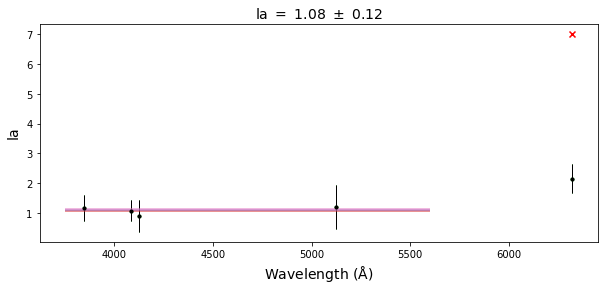

la number of lines: 5, good lines: 1
CPU times: user 4.06 s, sys: 242 ms, total: 4.3 s
Wall time: 4.64 s


In [19]:
%%time

elem_unique_lines, bad_line_elem, delta_abund_elem = merge_and_filter_all_lines(elem_to_merge=elem_to_merge, delta_abund_bad=1.0, std_abund_bad=1.0, max_no_change_delta_abund=15.0)

merge_abund_files(elem_to_merge, uves.spec_id.values, uves.monh.values, ion_to_merge=ion_to_merge, wls_to_filter=elem_unique_lines[bad_line_elem], 
                  wls_to_correct = elem_unique_lines[~bad_line_elem], gflogs_shift = delta_abund_elem[~bad_line_elem])

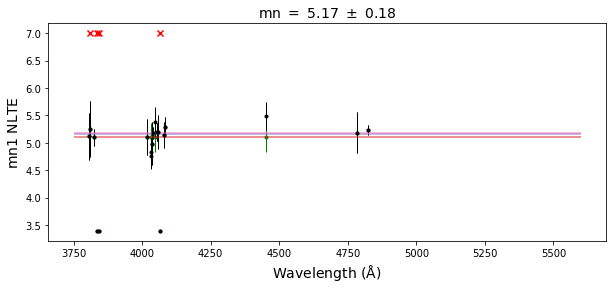

CPU times: user 7.69 s, sys: 259 ms, total: 7.95 s
Wall time: 11.3 s


In [39]:
%%time

elem_unique_lines_nlte, bad_line_elem_nlte, delta_abund_elem_nlte = merge_and_filter_all_nlte_lines(elem_to_merge=elem_to_merge, ion_to_merge=ion_to_merge)

merge_nlte_abund_files(elem_to_merge, uves.spec_id.values, uves.monh.values, ion_to_merge=ion_to_merge, wls_to_filter=elem_unique_lines_nlte[bad_line_elem_nlte], 
                  wls_to_correct = elem_unique_lines_nlte[~bad_line_elem_nlte], gflogs_shift = delta_abund_elem_nlte[~bad_line_elem_nlte])

In [310]:
#Test is files were correctly merged

In [118]:
# elem_merged = pd.read_csv('abunds_merged/uves_lines_mg1_merged.csv')
# star_lines = pd.read_csv('abunds_merged/uves_lines_mg1_1166634514845213568_3572891_000.csv')

elem_merged = pd.read_csv('abunds_merged/cayrel_all_th_lines_merged.csv', comment='s', skiprows=1)
# elem_merged = pd.read_csv('abunds_merged/uves_lines_mg1_merged.csv')
# star_lines = pd.read_csv('abunds_merged/uves_lines_mg1_1166634514845213568_3572891_000.csv')

In [119]:
# star_lines.head(10)
elem_merged.tail(8)

,01_HD2796,Th 2,4019.13,0.0,-0.228,0.670,0.337,0.134,16
61,32_CS29516_24,Th 2,4019.13,0.0000,-0.228,-6.364,5582387.402,4435053.574,6
62,32_CS29516_24,Th 2,4085.78,1.2633,-0.209,0.496,2.818,1.557,21
63,33_CS29518_51,Th 2,4019.13,0.0000,-0.228,0.615,0.370,0.367,16
64,33_CS29518_51,Th 2,4085.78,1.2633,-0.209,-2.556,6008.708,1603.637,16
65,34_CS30325_94,Th 2,4019.13,0.0000,-0.228,-3.187,4796.627,3186.018,16
66,34_CS30325_94,Th 2,4085.78,1.2633,-0.209,-3.187,64831.869,11311.370,16
67,35_CS31082_01,Th 2,4019.13,0.0000,-0.228,1.920,0.126,0.070,15
68,35_CS31082_01,Th 2,4085.78,1.2633,-0.209,2.071,0.138,0.166,19


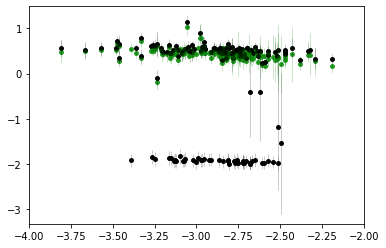

In [44]:
plt.scatter(uves.monh.values, elem_merged[ion_to_merge.lower().replace(' ', '')].values - 7.60, s=15, color='C2')
plt.errorbar(uves.monh.values, elem_merged[ion_to_merge.lower().replace(' ', '')].values - 7.60, fmt='g.', yerr=elem_merged['e%s_rms' %ion_to_merge.lower().replace(' ', '')].values, alpha=0.2, lw=1)

plt.scatter(uves.monh.values, elem_merged_nlte['%s_nlte' %ion_to_merge.lower().replace(' ', '')].values - 7.60, s=15, color='k')
plt.errorbar(uves.monh.values, elem_merged_nlte['%s_nlte' %ion_to_merge.lower().replace(' ', '')].values - 7.60, fmt='k.', 
             yerr=elem_merged_nlte['e%s_nlte_rms' %ion_to_merge.lower().replace(' ', '')].values, alpha=0.2, lw=1)
plt.xlim(-4, -2)
# plt.ylim(-0.25, 1.5)
plt.show()

In [36]:
# plt.scatter(uves.monh.values, elem_merged[ion_to_merge.lower().replace(' ', '')].values - 7.60, s=15, color='k')
# plt.errorbar(uves.monh.values, elem_merged[ion_to_merge.lower().replace(' ', '')].values - 7.60, fmt='k.', yerr=elem_merged['e%s_rms' %ion_to_merge.lower().replace(' ', '')].values, alpha=0.2, lw=1)
# plt.xlim(-4, -2)
# # plt.ylim(-0.25, 1.5)
# plt.show()

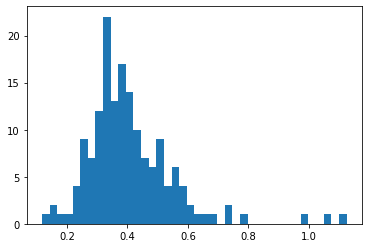

In [352]:
plt.hist(elem_merged.esi1_rms.values, bins=40)
plt.show()

In [238]:
elem_merged.query('eti1_rms > 0.25')

,spec_id,ti1,eti1_rms,eti1_sme,n_lines_ti1,min_iters_ti1
68,5454289027730222848_3708466_149,5.193415,0.285996,0.1985,22,12
94,6425379106130933376_3573700_088,5.566729,0.471782,0.3575,22,9


In [239]:
uves.query('spec_id == "6425379106130933376_3573700_088"').monh

94   -3.810066
Name: monh, dtype: float64

In [ ]:
#OLD CODE FROM HERE!!

In [55]:
os.system('cat tmp_elems/uves_elem_lines_%s*.csv > abunds_merged/uves_all_%s_lines_merged.csv' %(elem_to_merge, elem_to_merge));

In [57]:
elem = pd.read_csv('abunds_merged/uves_%s_merged_lines.csv' %elem_to_merge, 
                   names=['spec_id','species','wl_line','excit','gflog',elem_to_merge,'e%s_sme' %elem_to_merge,
                          'e%s_fit' %elem_to_merge,'n_iter_%s' %elem_to_merge], comment='s')

In [58]:
elem_unique_lines, elem_unique_lines_counts = np.unique(elem.wl_line.values, return_counts=True)
grouped_stats_elem = elem.groupby('wl_line')[elem_to_merge].agg(['median', mad_std])

In [59]:
elem_ref = elem.query('wl_line == %4.2f' %elem_unique_lines[np.argmin(grouped_stats_elem['mad_std'].values)])[elem_to_merge].values

In [60]:
line_madstd_elem = grouped_stats_elem['mad_std'].values
line_median_elem = grouped_stats_elem['median'].values
delta_abund_elem = line_median_elem - np.median(elem_ref)

In [61]:
bad_line_elem = (np.abs(delta_abund_elem) > 0.50) | (line_madstd_elem > 0.50)
delta_abund_elem[bad_line_elem] = 0.0
delta_abund_elem[np.abs(delta_abund_elem) < 0.25] = 0.0
# bad_line_elem[np.abs(delta_abund_elem) < 0.25] = False

In [62]:
# # Optional plot
# plt.figure(figsize=(10,5))

# plt.errorbar(grouped_stats_elem.index, grouped_stats_elem['median'].values, yerr=grouped_stats_elem['mad_std'].values, fmt='k.', lw=1)
# plt.errorbar(grouped_stats_elem.index, grouped_stats_elem['median'].values - delta_abund_elem, yerr=grouped_stats_elem['mad_std'].values, fmt='g.', lw=1, zorder=0)
# plt.hlines(np.median(elem_ref), 3750, 5600, color='C3', lw=2, alpha=0.5)
# plt.scatter(grouped_stats_elem.index[bad_line_elem], 6+np.ones_like(grouped_stats_elem.index[bad_line_elem]), marker='x', color='r')
# plt.hlines(np.average(grouped_stats_elem['median'].values[~bad_line_elem], weights=1./grouped_stats_elem['mad_std'].values[~bad_line_elem]**2.), 3750, 5600, color='C4', lw=2, alpha=0.5)
# plt.hlines(np.median(grouped_stats_elem['median'].values[~bad_line_elem]), 3750, 5600, color='C6', lw=2, alpha=0.5)

# plt.show()
# plt.close()

In [9]:
# Reject or correct lines

In [10]:
# Merge line files
os.system('cat tmp_elems/uves_elem_lines_mg*.csv > tmp_merged/uves_mg_merged_lines.csv');
os.system('cat tmp_elems/uves_elem_lines_ca*.csv > tmp_merged/uves_ca_merged_lines.csv');

In [11]:
mg = pd.read_csv('tmp_merged/uves_mg_merged_lines.csv', names=['spec_id','species','wl_line','excit','gflog','mg','emg_sme','emg_fit','n_iter_mg'], comment='s')
ca = pd.read_csv('tmp_merged/uves_ca_merged_lines.csv', names=['spec_id','species','wl_line','excit','gflog','ca','eca_sme','eca_fit','n_iter_ca'], comment='s')

In [12]:
mg_unique_lines, mg_unique_lines_counts = np.unique(mg.wl_line.values, return_counts=True)
ca_unique_lines, ca_unique_lines_counts = np.unique(ca.wl_line.values, return_counts=True)

In [13]:
grouped_stats_mg = mg.groupby('wl_line')['mg'].agg(['median', 'mean', 'std', mad_std])
grouped_stats_ca = ca.groupby('wl_line')['ca'].agg(['median', 'mean', 'std', mad_std])

In [14]:
mg_ref = mg.query('wl_line == %4.2f' %mg_unique_lines[np.argmin(grouped_stats_mg['std'].values)]).mg.values
ca_ref = ca.query('wl_line == %4.2f' %ca_unique_lines[np.argmin(grouped_stats_ca['std'].values)]).ca.values

In [15]:
line_std_mg = grouped_stats_mg['std'].values
line_madstd_mg = grouped_stats_mg['std'].values
line_median_mg = grouped_stats_mg['median'].values
delta_abund_mg = grouped_stats_mg['median'].values - np.median(mg_ref)

line_std_ca = grouped_stats_ca['std'].values
line_median_ca = grouped_stats_ca['median'].values
delta_abund_ca = grouped_stats_ca['median'].values - np.median(ca_ref)

In [16]:
line_std_mg

array([0.5305193 , 0.20298061, 0.19038679, 0.65634615, 1.34422054,
       1.58764776, 0.35550619, 0.32683895, 0.74119645, 1.1255767 ,
       0.23678069, 0.11992922, 0.12324695, 0.95307325])

In [17]:
bad_line_mg = (np.abs(delta_abund_mg) > 0.5) | (line_std_mg > 0.50) 
delta_abund_mg[bad_line_mg] = 0.0
delta_abund_mg[np.abs(delta_abund_mg) < 0.25] = 0.0

bad_line_ca = (np.abs(delta_abund_ca) > 0.5) | (line_std_ca > 0.50) 
delta_abund_ca[bad_line_ca] = 0.0
delta_abund_ca[np.abs(delta_abund_ca) < 0.10] = 0.0

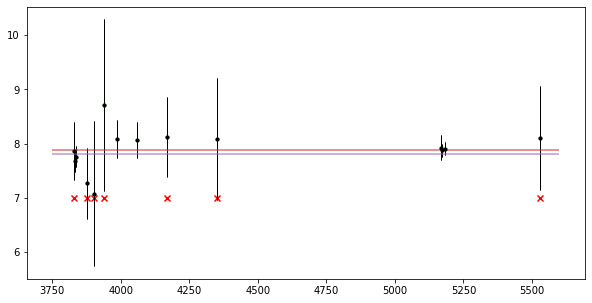

In [18]:
plt.figure(figsize=(10,5))

plt.errorbar(grouped_stats_mg.index, grouped_stats_mg['median'].values, yerr=grouped_stats_mg['std'].values, fmt='k.', lw=1)
plt.errorbar(grouped_stats_mg.index, grouped_stats_mg['median'].values - delta_abund_mg, yerr=grouped_stats_mg['std'].values, fmt='g.', lw=1, zorder=0)
plt.hlines(np.median(mg_ref), 3750, 5600, color='C3', lw=2, alpha=0.5)
plt.scatter(grouped_stats_mg.index[bad_line_mg], 6+np.ones_like(grouped_stats_mg.index[bad_line_mg]), marker='x', color='r')
plt.hlines(np.average(grouped_stats_mg['median'].values[bad_line_mg], weights=1./grouped_stats_mg['std'].values[bad_line_mg]**2.), 3750, 5600, color='C4', lw=2, alpha=0.5)

# plt.errorbar(grouped_stats_ca.index, grouped_stats_ca['median'].values, yerr=grouped_stats_ca['std'].values, fmt='k.', lw=1)
# plt.errorbar(grouped_stats_ca.index, grouped_stats_ca['median'].values - delta_abund_ca, yerr=grouped_stats_ca['std'].values, fmt='g.', lw=1, zorder=0)
# plt.hlines(np.median(ca_ref), 3750, 6500, color='C3', lw=2, alpha=0.5)
# plt.scatter(grouped_stats_ca.index[bad_line_ca], 6+np.ones_like(grouped_stats_ca.index[bad_line_ca]), marker='x', color='r')
# plt.hlines(np.average(grouped_stats_ca['median'].values[~bad_line_ca], weights=1./grouped_stats_ca['std'].values[~bad_line_ca]**2.), 3750, 6500, color='C4', lw=2, alpha=0.5)

plt.show()

In [19]:
np.median(mg_ref), np.average(grouped_stats_mg['median'].values[~bad_line_mg], weights=1./grouped_stats_mg['std'].values[~bad_line_mg]**2.)

(7.873, 7.868012489212101)

In [20]:
np.median(ca_ref), np.average(grouped_stats_ca['median'].values[~bad_line_ca], weights=1./grouped_stats_ca['std'].values[~bad_line_ca]**2.)

(6.6335, 6.647607557314772)

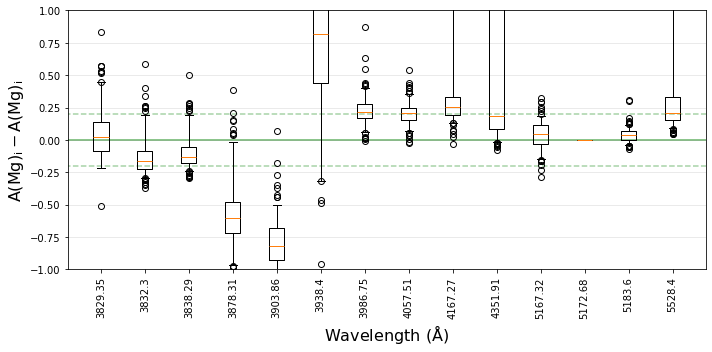

In [21]:
plt.figure(figsize=(10,5))

for n_line, wl_line in enumerate(mg_unique_lines):
    abunds = mg.query('wl_line == %4.2f' %mg_unique_lines[n_line])
    abunds.reset_index(inplace=True)
    
    plt.boxplot(np.vstack((abunds.mg.values-mg_ref[abunds.index.values])), positions = [n_line], sym='o', widths=0.35, whis=(5, 95), showmeans=False)

plt.gca().yaxis.grid('True', alpha=0.2, color='grey')
plt.xticks(np.arange(0, mg_unique_lines.size), mg_unique_lines, rotation=90)
plt.ylabel(r'${\rm A(Mg)_i - A(Mg)_i}$', size=16)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', size=16)
plt.ylim(-3, 3)
plt.ylim(-1, 1)
plt.xlim(-0.75, 13.75)
plt.hlines([-0.20, 0.20], -1, 14, zorder=0, color='g', alpha=0.35, ls='--', lw=1.5)
plt.hlines(0.0, -1, 14, zorder=-1, color='g', alpha=0.6, ls='-', lw=1.5)

plt.tight_layout()
plt.show()

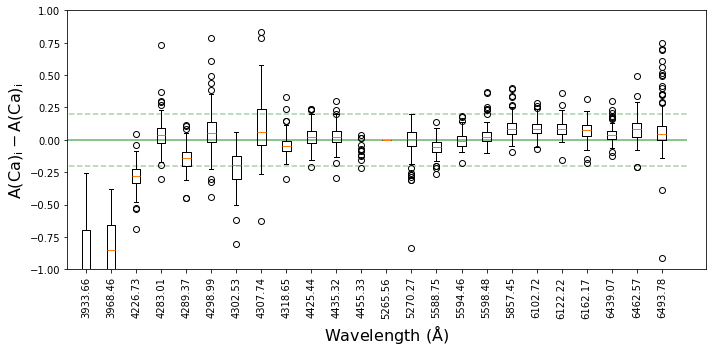

In [22]:
plt.figure(figsize=(10,5))

for n_line, wl_line in enumerate(ca_unique_lines):
    abunds = ca.query('wl_line == %4.2f' %ca_unique_lines[n_line])
    abunds.reset_index(inplace=True)
    
    plt.boxplot(np.vstack((abunds.ca.values-ca_ref[abunds.index.values])), positions = [n_line], sym='o', widths=0.35, whis=1.5, showmeans=False)

# plt.gca().yaxis.grid('True', alpha=0.25, color='grey')
plt.xticks(np.arange(0, ca_unique_lines.size), ca_unique_lines, rotation=90)
plt.ylabel(r'${\rm A(Ca)_i - A(Ca)_i}$', size=16)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', size=16)
plt.ylim(-3, 3)
plt.ylim(-1, 1)
plt.xlim(-0.75, 24.75)
plt.hlines([-0.20, 0.20], -1, 24, zorder=0, color='g', alpha=0.35, ls='--', lw=1.5)
plt.hlines(0.0, -1, 24, zorder=-1, color='g', alpha=0.6, ls='-', lw=1.5)

plt.tight_layout()
plt.show()

In [23]:
# Merge based on information

In [24]:
def merge_abund_files(elem_to_merge, spec_ids, monhs, ion_to_merge = None, wls_to_filter = None, wls_to_correct = None, gflogs_shift = None):

    if len(wls_to_filter) == 0: wls_to_filter = None
    if len(wls_to_correct) == 0: wls_to_correct = None
    if len(gflogs_shift) == 0: gflogs_shift = None

    for spec_id, monh in zip(spec_ids, monhs):
        df = pd.read_csv('tmp_elems/uves_elem_lines_%s_%s.csv' %(elem_to_merge, spec_id))
        # print(df)
        if ion_to_merge != None: df = df.query('species == "%s"' %ion_to_merge)

        if wls_to_filter is not None:
            for wl_to_filter in wls_to_filter:
                if wl_to_filter in np.unique(df.wl_line.values):
                    df = df.query('wl_line != %4.2f' %wl_to_filter)
                    df.reset_index(drop=True, inplace=True)

        if (wls_to_correct is not None) and (gflogs_shift is not None):
            for wl_to_correct, gflog_shift in zip(wls_to_correct, gflogs_shift):
                if wl_to_correct in np.unique(df.wl_line.values):
                    df.loc[df.query('wl_line == %4.2f' %wl_to_correct).index.values, '%s' %elem_to_merge] = df.query('wl_line == %4.2f' %wl_to_correct)['%s' %elem_to_merge].values + gflog_shift
                    
        df['loge%s' %elem_to_merge.capitalize()] = df['%s' %elem_to_merge].values + monh
    
        condition = '%s < 10 and e%s_sme < 0.5 and e%s_sme != 0.0 and n_iter_%s > 1' %(elem_to_merge, elem_to_merge, elem_to_merge, elem_to_merge)
        df = df.query(condition)
        print(df)

        if df.spec_id.size > 1:
            average = np.average(a = df['%s' %elem_to_merge].values, weights=1./df['e%s_sme' %elem_to_merge].values**2.)
            rms = np.average((average - df['%s' %elem_to_merge].values)**2., weights=1./df['e%s_sme' %elem_to_merge].values**2.)**0.5
            e_sme_mean = np.mean(df['e%s_sme' %elem_to_merge].values)
            n_lines = df['e%s_sme' %elem_to_merge].size
            min_n_iters, max_n_iters = np.min(df['n_iter_%s' %elem_to_merge].values), np.max(df['n_iter_%s' %elem_to_merge].values)
        else:
            average = df['%s' %elem_to_merge].values
            rms = df['e%s_sme' %elem_to_merge].values
            e_sme_mean = df['%s' %elem_to_merge].values
            n_lines = 1
            min_n_iters, max_n_iters = np.min(df['n_iter_%s' %elem_to_merge].values), np.max(df['n_iter_%s' %elem_to_merge].values)

        print(average, rms, e_sme_mean, n_lines, min_n_iters, max_n_iters)
        
        return
    
    return

In [25]:
merge_abund_files('mg', uves.spec_id.values, uves.monh.values, ion_to_merge='Mg 1', wls_to_filter=mg_unique_lines[bad_line_mg], 
                  wls_to_correct = mg_unique_lines[~bad_line_mg], gflogs_shift = -delta_abund_mg[~bad_line_mg])

                           spec_id species  wl_line   excit  gflog     mg  \
1  1166634514845213568_3572891_000    Mg 1  3838.29  2.7166 -1.527  7.758   
2  1166634514845213568_3572891_000    Mg 1  3986.75  4.3458 -1.060  8.054   
3  1166634514845213568_3572891_000    Mg 1  4057.51  4.3458 -0.900  8.138   
4  1166634514845213568_3572891_000    Mg 1  5167.32  2.7091 -0.931  7.947   
5  1166634514845213568_3572891_000    Mg 1  5172.68  2.7116 -0.450  7.888   
6  1166634514845213568_3572891_000    Mg 1  5183.60  2.7166 -0.239  7.964   

   emg_sme  emg_fit  n_iter_mg    logeMg  
1    0.393    0.056         13  4.980851  
2    0.456    0.096         18  5.276851  
3    0.222    0.060         12  5.360851  
4    0.415    0.051         13  5.169851  
5    0.351    0.042         15  5.110851  
6    0.218    0.031         12  5.186851  
7.992765202618379 0.11768344303484597 0.3425 6 12 18


In [26]:
merge_abund_files('ca', uves.spec_id.values, uves.monh.values, ion_to_merge='Ca 1', wls_to_filter=ca_unique_lines[bad_line_ca], 
                  wls_to_correct = ca_unique_lines[~bad_line_ca], gflogs_shift = -delta_abund_ca[~bad_line_ca])

                            spec_id species  wl_line   excit  gflog     ca  \
0   1166634514845213568_3572891_000    Ca 1  4226.73  0.0000  0.244  6.706   
1   1166634514845213568_3572891_000    Ca 1  4283.01  1.8858 -0.136  6.759   
2   1166634514845213568_3572891_000    Ca 1  4298.99  1.8858 -0.359  6.738   
4   1166634514845213568_3572891_000    Ca 1  4318.65  1.8989 -0.139  6.665   
5   1166634514845213568_3572891_000    Ca 1  4425.44  1.8793 -0.358  6.752   
6   1166634514845213568_3572891_000    Ca 1  4435.32  1.8858 -0.007  6.631   
7   1166634514845213568_3572891_000    Ca 1  5265.56  2.5230 -0.113  6.697   
8   1166634514845213568_3572891_000    Ca 1  5588.75  2.5257  0.358  6.647   
9   1166634514845213568_3572891_000    Ca 1  5594.46  2.5230  0.097  6.647   
10  1166634514845213568_3572891_000    Ca 1  5598.48  2.5213 -0.087  6.623   
11  1166634514845213568_3572891_000    Ca 1  5857.45  2.9325  0.240  6.871   
12  1166634514845213568_3572891_000    Ca 1  6102.72  1.8793 -0.

In [31]:
print('Unique Mg lines: %d/%d' %(mg_unique_lines[~bad_line_mg].size, bad_line_mg.size))
print('Unique Ca lines: %d/%d' %(ca_unique_lines[~bad_line_ca].size, bad_line_ca.size))

Unique Mg lines: 7/14
Unique Ca lines: 18/24


In [ ]:
delta_abund_ca.size

